<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_8_Generation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализовать синтезирование лиц из LFW с помощью DCGAN.
 Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    with_info=True,
    split='train'
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

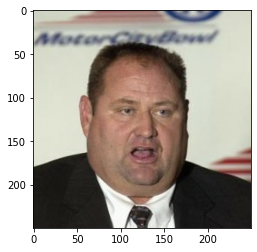

In [5]:
for example in train_ds.take(1):  # Only take a single example
    image = example['image']
    plt.imshow(image.numpy().astype(np.float32)/255)

In [0]:
train_x = [tf.image.rgb_to_grayscale(x['image'].numpy().reshape(250, 250, 3)) for x in train_ds]

In [7]:
train_x[0].shape

TensorShape([250, 250, 1])

In [8]:
len(train_x)

13233

## Deep Convolutional GAN (DCGAN)

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

##Подготовка датасета

In [0]:
def prepare(img):
  img = tf.cast(img, tf.float32) / 255.
  return tf.image.resize(img, (28, 28))

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 50
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=len(train_x))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
train_ds

<BatchDataset shapes: (16, 28, 28, 1), types: tf.float32>

In [0]:
def plot_pics(samples):
    fig = plt.figure(figsize=(20, 20))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(6, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 1.3490; G Loss: 0.6872


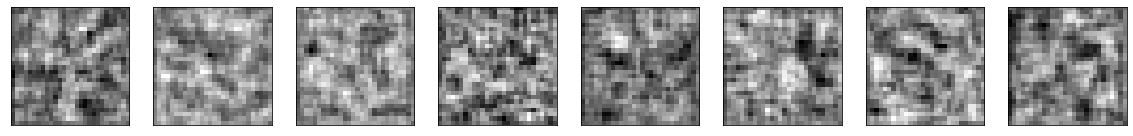

[Step 500] D Loss: 0.9547; G Loss: 1.2398


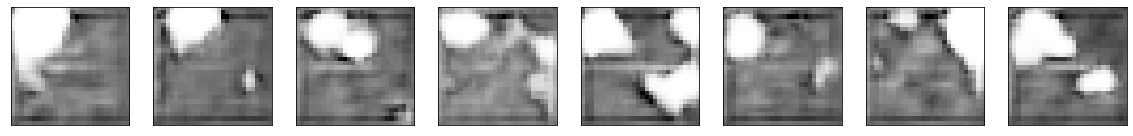

[Step 1000] D Loss: 0.6618; G Loss: 0.3382


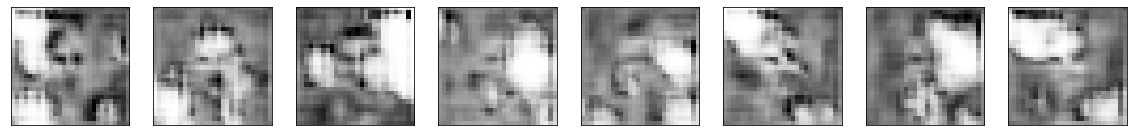

[Step 1500] D Loss: 0.6775; G Loss: 1.3726


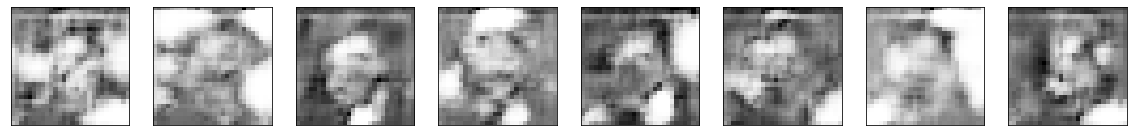

[Step 2000] D Loss: 0.9565; G Loss: 0.6115


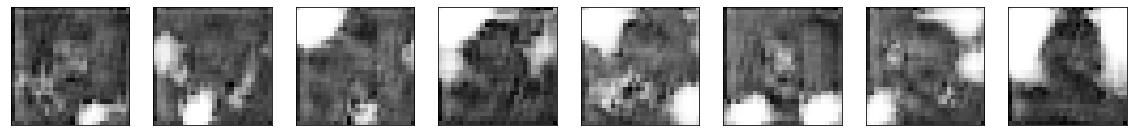

[Step 2500] D Loss: 0.7912; G Loss: 0.7604


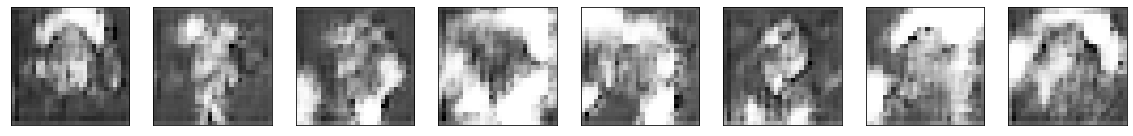

[Step 3000] D Loss: 0.5708; G Loss: 0.7338


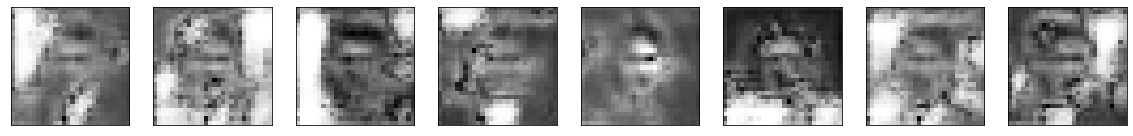

[Step 3500] D Loss: 0.6717; G Loss: 0.9862


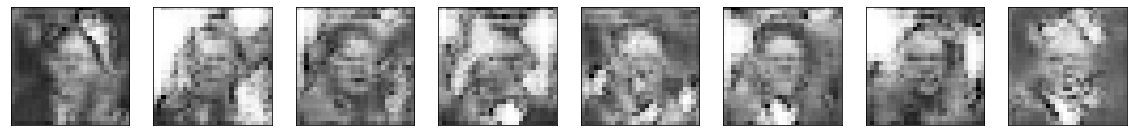

[Step 4000] D Loss: 0.6190; G Loss: 1.1867


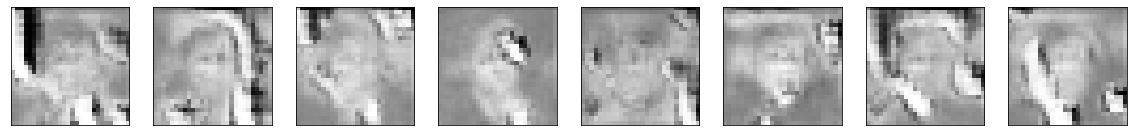

[Step 4500] D Loss: 0.6387; G Loss: 1.1408


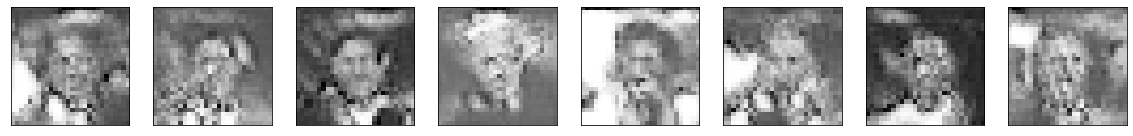

[Step 5000] D Loss: 0.8743; G Loss: 0.5694


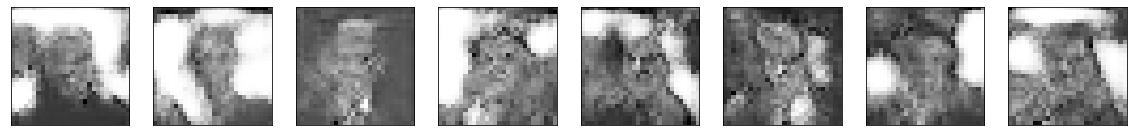

[Step 5500] D Loss: 0.5421; G Loss: 1.5700


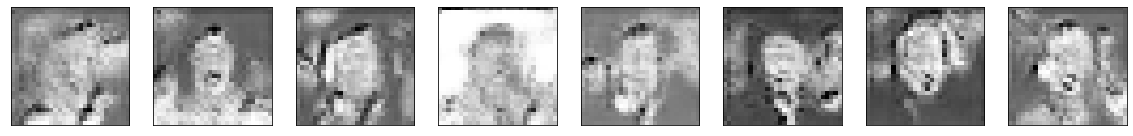

[Step 6000] D Loss: 0.5014; G Loss: 1.2202


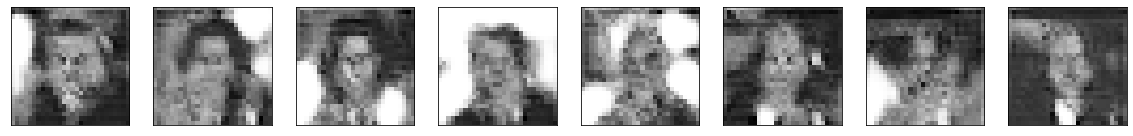

[Step 6500] D Loss: 0.7445; G Loss: 2.0339


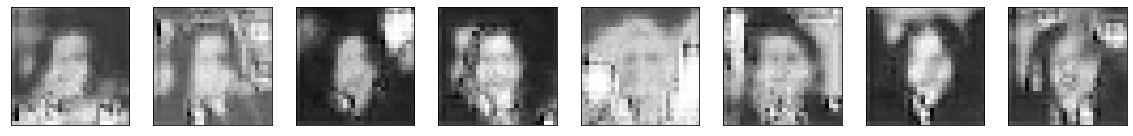

[Step 7000] D Loss: 0.3824; G Loss: 1.1739


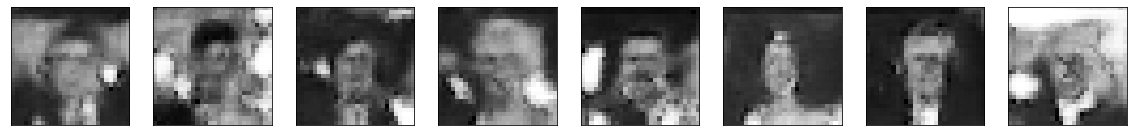

[Step 7500] D Loss: 0.4752; G Loss: 1.0720


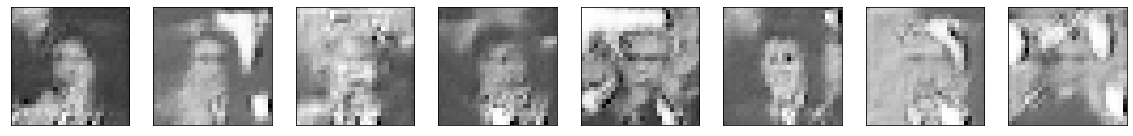

[Step 8000] D Loss: 0.4919; G Loss: 2.5093


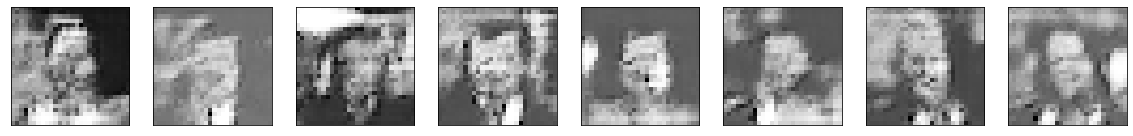

[Step 8500] D Loss: 0.7388; G Loss: 1.3385


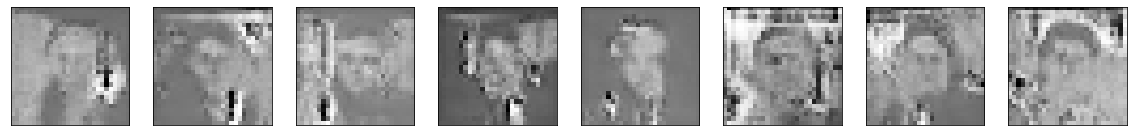

[Step 9000] D Loss: 0.5357; G Loss: 1.5331


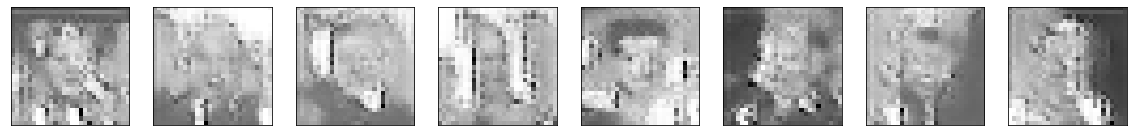

[Step 9500] D Loss: 0.5242; G Loss: 1.0292


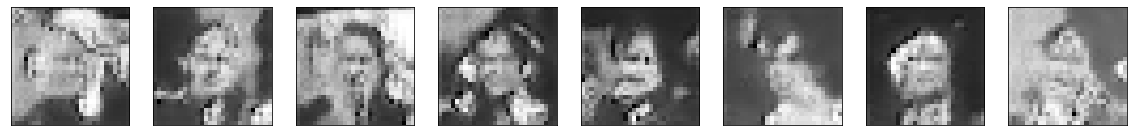

[Step 10000] D Loss: 0.4854; G Loss: 1.7123


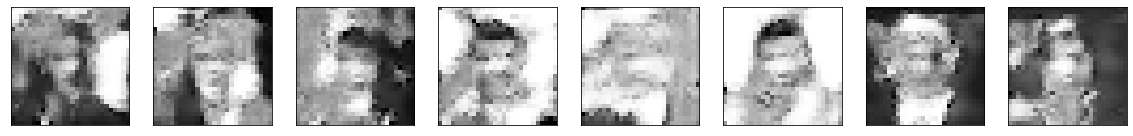

[Step 10500] D Loss: 0.4658; G Loss: 1.2725


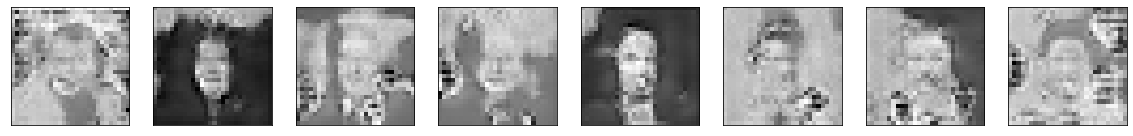

[Step 11000] D Loss: 0.6199; G Loss: 1.6778


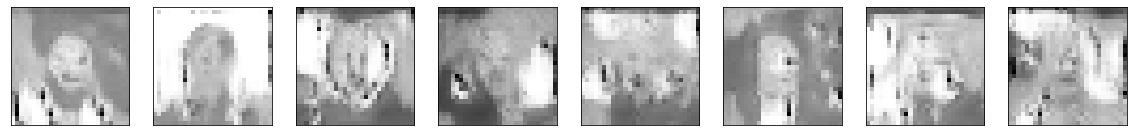

[Step 11500] D Loss: 0.6086; G Loss: 0.9826


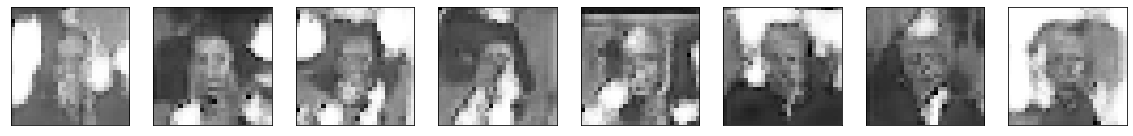

[Step 12000] D Loss: 0.6661; G Loss: 1.1463


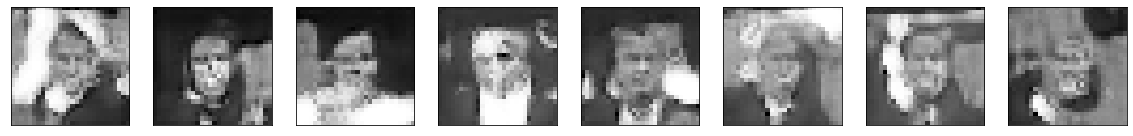

[Step 12500] D Loss: 0.5637; G Loss: 1.7215


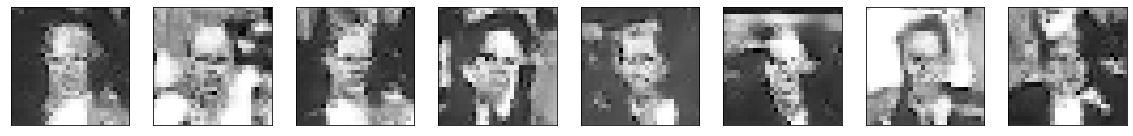

[Step 13000] D Loss: 0.5758; G Loss: 1.0037


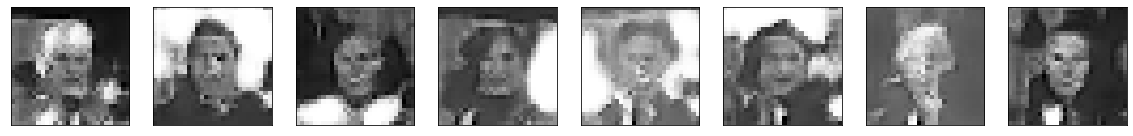

[Step 13500] D Loss: 0.7415; G Loss: 1.1446


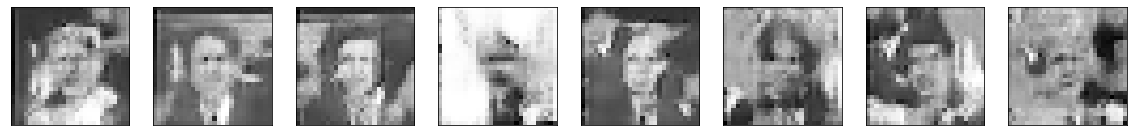

[Step 14000] D Loss: 0.6382; G Loss: 1.2008


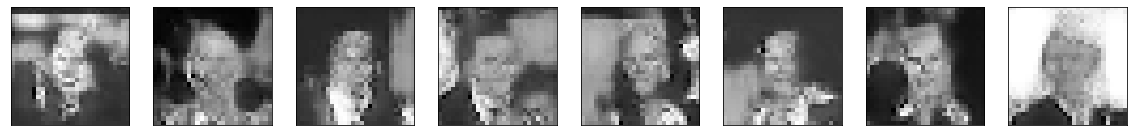

[Step 14500] D Loss: 0.6240; G Loss: 1.5697


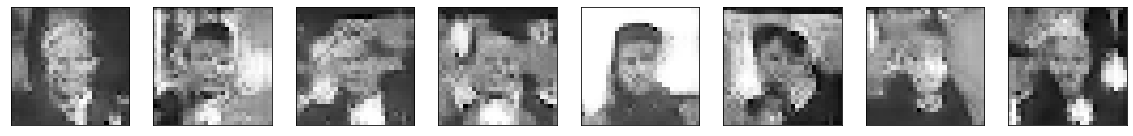

[Step 15000] D Loss: 0.6537; G Loss: 0.7877


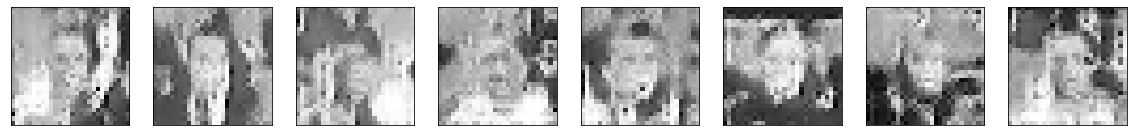

[Step 15500] D Loss: 0.7007; G Loss: 1.2174


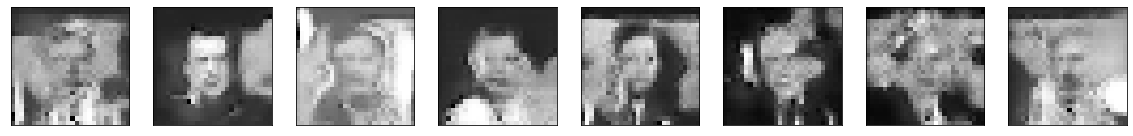

[Step 16000] D Loss: 0.5353; G Loss: 0.6368


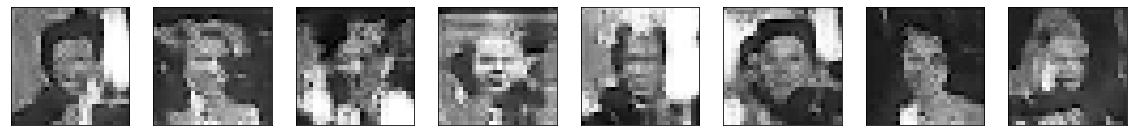

[Step 16500] D Loss: 0.5459; G Loss: 1.4946


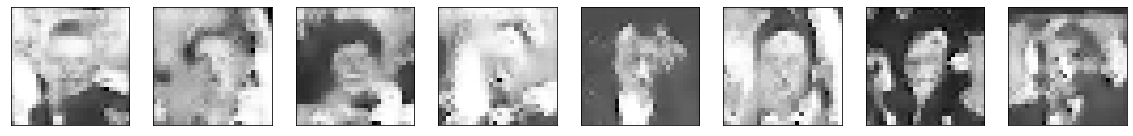

[Step 17000] D Loss: 0.7093; G Loss: 0.5291


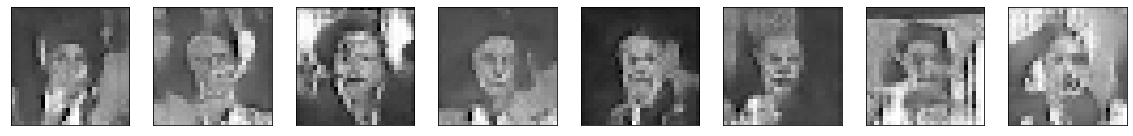

[Step 17500] D Loss: 0.5443; G Loss: 1.3140


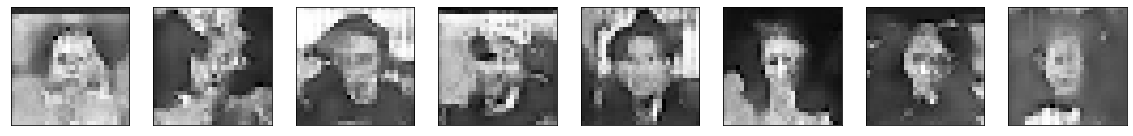

[Step 18000] D Loss: 0.6448; G Loss: 0.9478


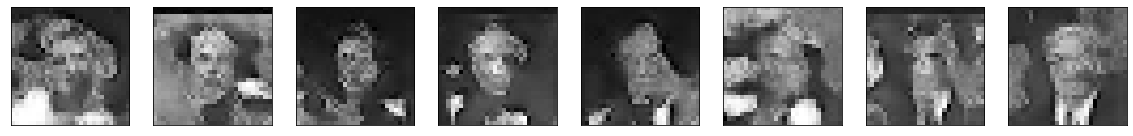

[Step 18500] D Loss: 0.6143; G Loss: 0.9358


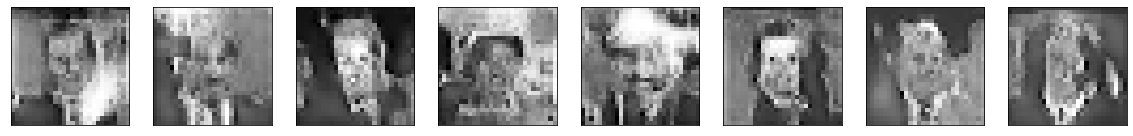

[Step 19000] D Loss: 0.8834; G Loss: 0.9233


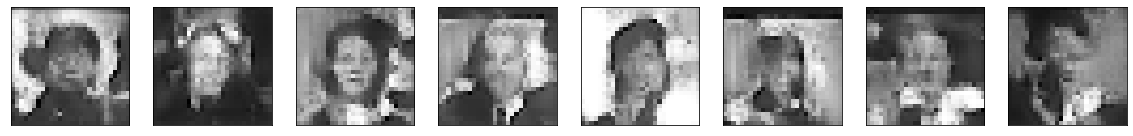

[Step 19500] D Loss: 0.5962; G Loss: 1.4288


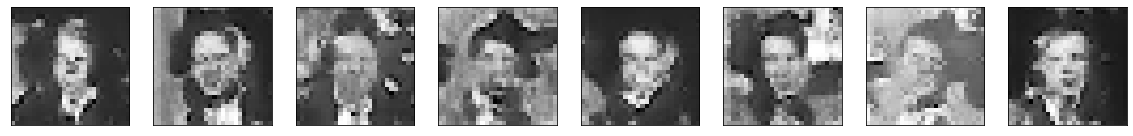

[Step 20000] D Loss: 0.5622; G Loss: 0.8557


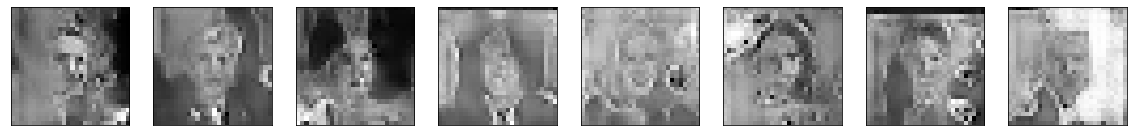

[Step 20500] D Loss: 0.6407; G Loss: 1.0057


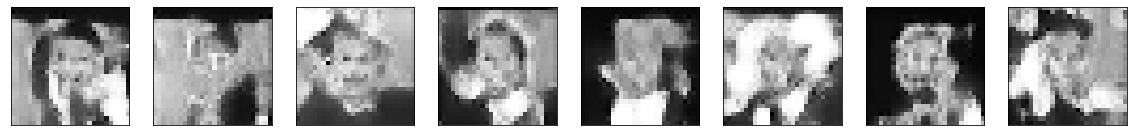

[Step 21000] D Loss: 0.5848; G Loss: 1.0489


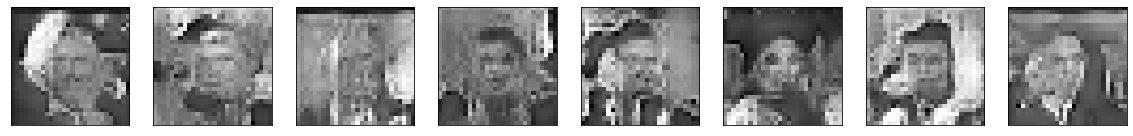

[Step 21500] D Loss: 0.7093; G Loss: 0.9240


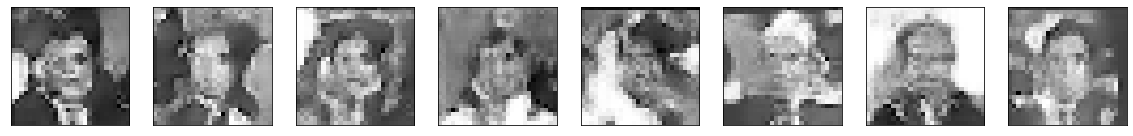

[Step 22000] D Loss: 0.5818; G Loss: 0.9575


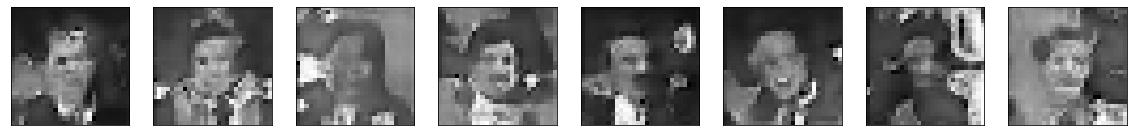

[Step 22500] D Loss: 0.8202; G Loss: 0.4367


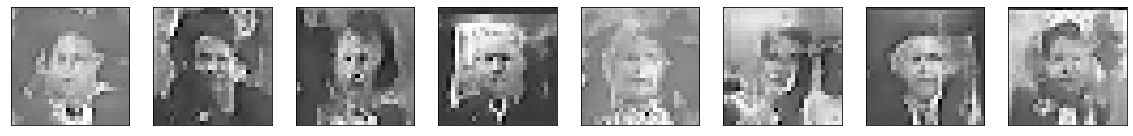

[Step 23000] D Loss: 0.7124; G Loss: 0.6111


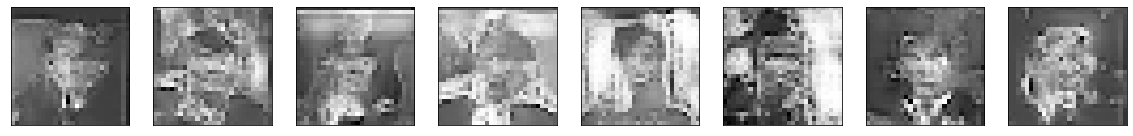

[Step 23500] D Loss: 0.8078; G Loss: 0.9340


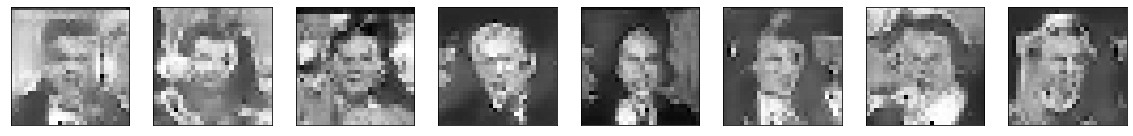

[Step 24000] D Loss: 0.6443; G Loss: 0.8551


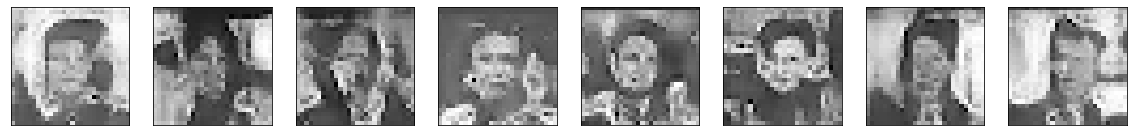

[Step 24500] D Loss: 0.5212; G Loss: 0.7702


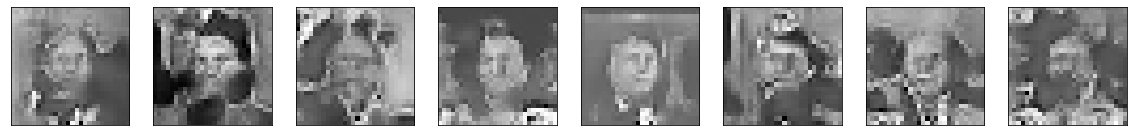

[Step 25000] D Loss: 0.7121; G Loss: 0.7152


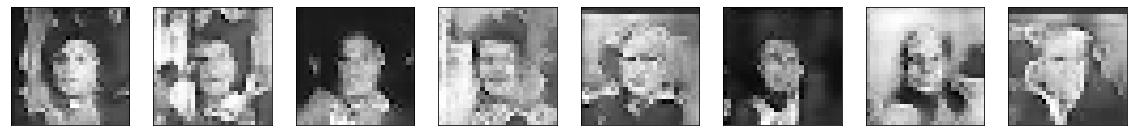

[Step 25500] D Loss: 0.6549; G Loss: 0.6680


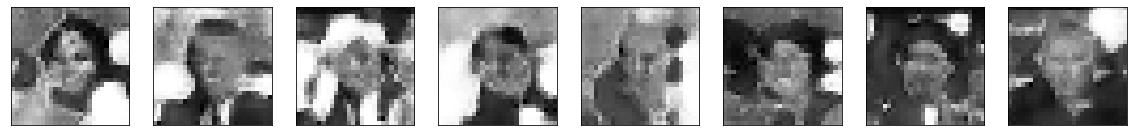

[Step 26000] D Loss: 0.4747; G Loss: 1.1367


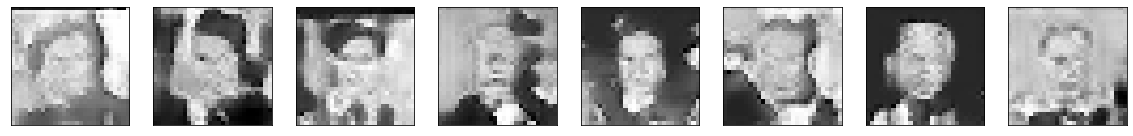

[Step 26500] D Loss: 0.6147; G Loss: 0.8525


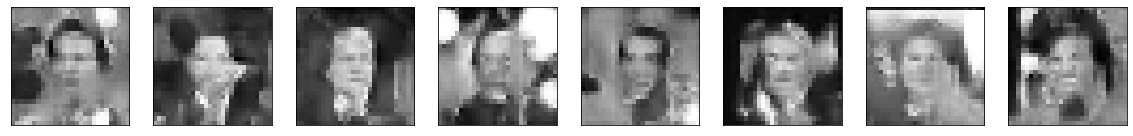

[Step 27000] D Loss: 0.7404; G Loss: 0.7584


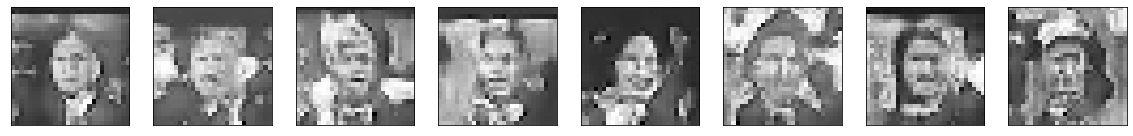

[Step 27500] D Loss: 0.5004; G Loss: 0.8682


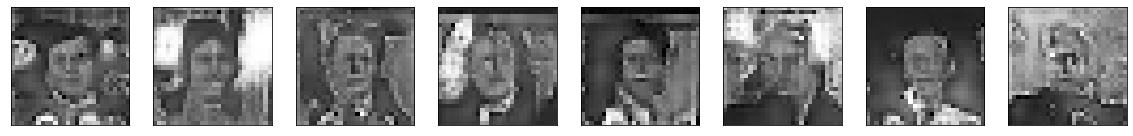

[Step 28000] D Loss: 0.6758; G Loss: 0.9765


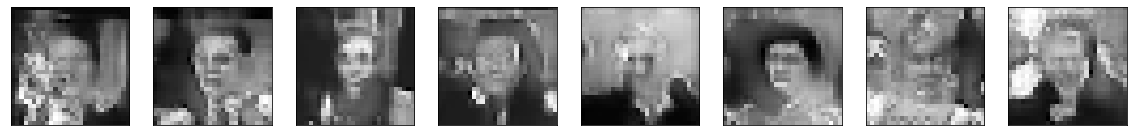

[Step 28500] D Loss: 0.6560; G Loss: 0.9189


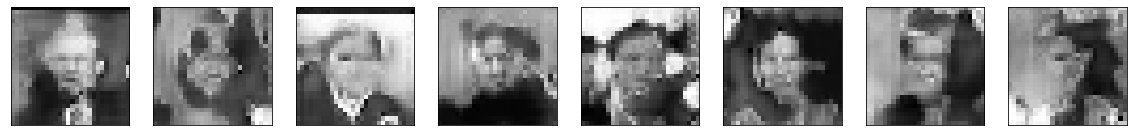

[Step 29000] D Loss: 0.7128; G Loss: 0.8330


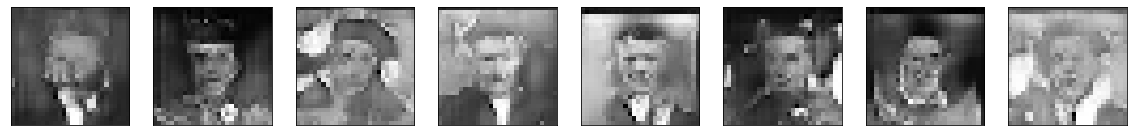

[Step 29500] D Loss: 0.7880; G Loss: 0.6563


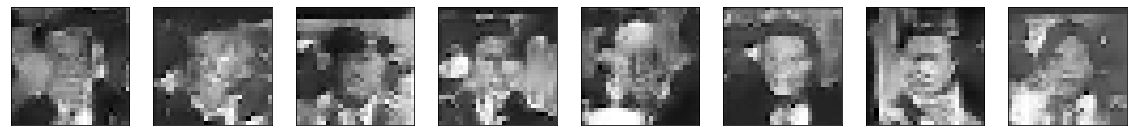

[Step 30000] D Loss: 0.6458; G Loss: 0.8284


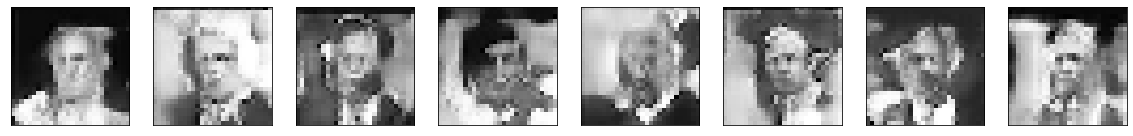

[Step 30500] D Loss: 0.5834; G Loss: 0.6745


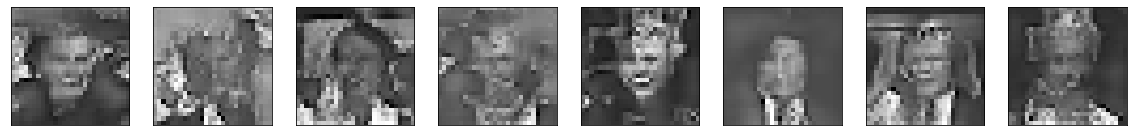

[Step 31000] D Loss: 0.4602; G Loss: 1.1061


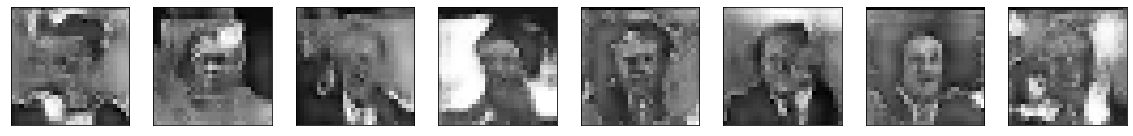

[Step 31500] D Loss: 0.5774; G Loss: 0.8872


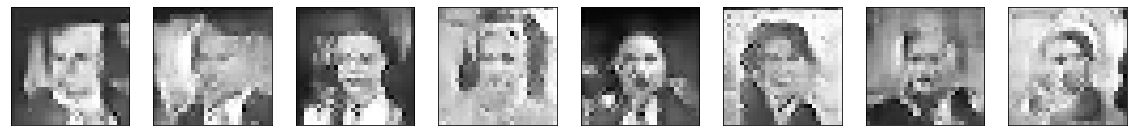

[Step 32000] D Loss: 0.7655; G Loss: 0.7878


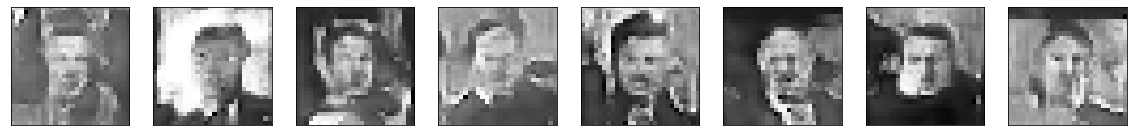

[Step 32500] D Loss: 0.6844; G Loss: 0.7535


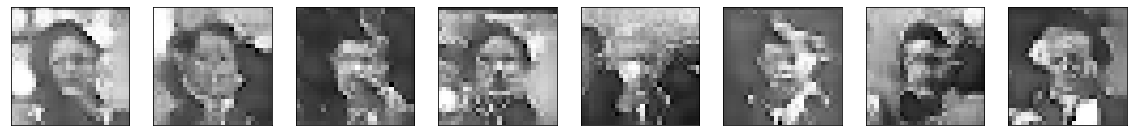

[Step 33000] D Loss: 0.7501; G Loss: 0.5319


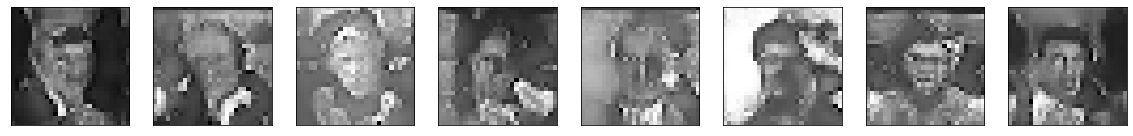

[Step 33500] D Loss: 0.7228; G Loss: 0.9102


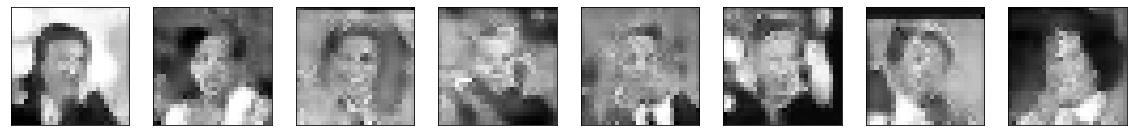

[Step 34000] D Loss: 0.6027; G Loss: 0.9782


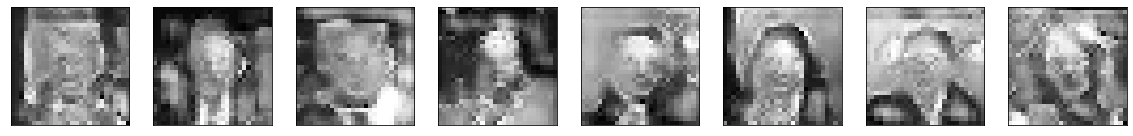

[Step 34500] D Loss: 0.7030; G Loss: 1.0993


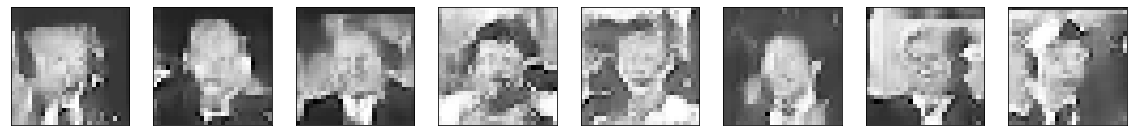

[Step 35000] D Loss: 0.5463; G Loss: 0.8095


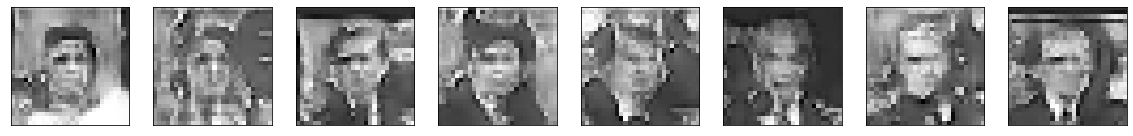

[Step 35500] D Loss: 0.6387; G Loss: 0.9611


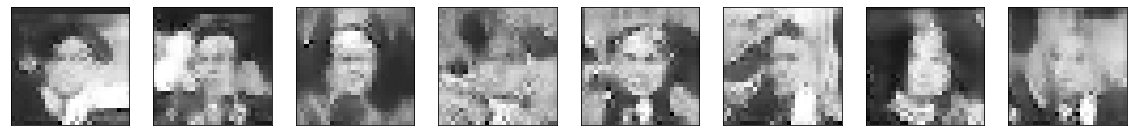

[Step 36000] D Loss: 0.6045; G Loss: 0.8721


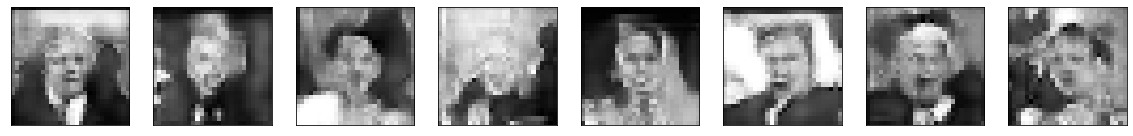

[Step 36500] D Loss: 0.8738; G Loss: 0.6581


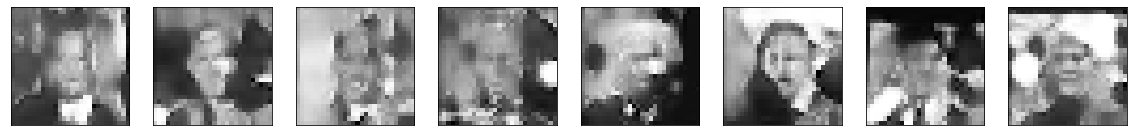

[Step 37000] D Loss: 0.7518; G Loss: 0.5357


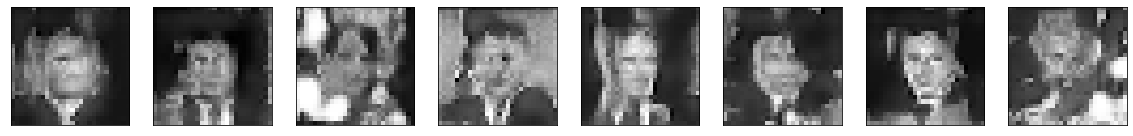

[Step 37500] D Loss: 0.6379; G Loss: 0.9323


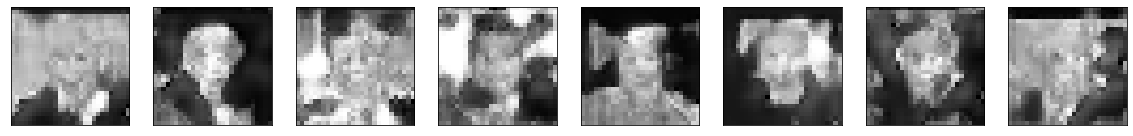

[Step 38000] D Loss: 0.6239; G Loss: 0.7920


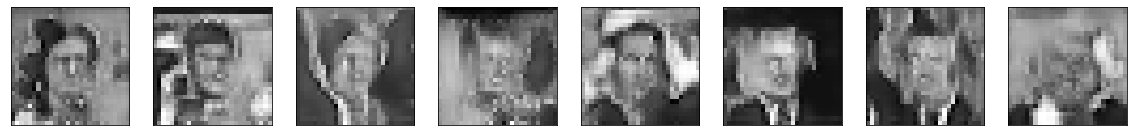

[Step 38500] D Loss: 0.6169; G Loss: 1.0478


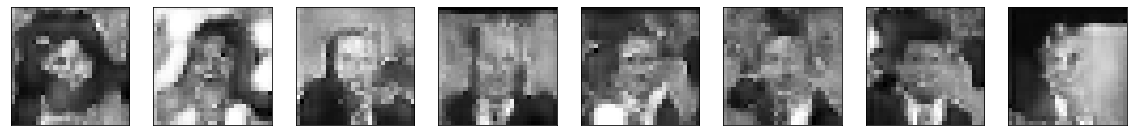

[Step 39000] D Loss: 0.7891; G Loss: 0.6600


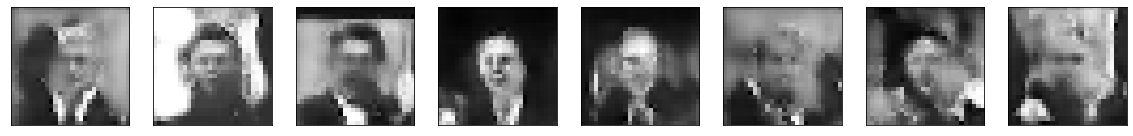

[Step 39500] D Loss: 0.6672; G Loss: 0.6785


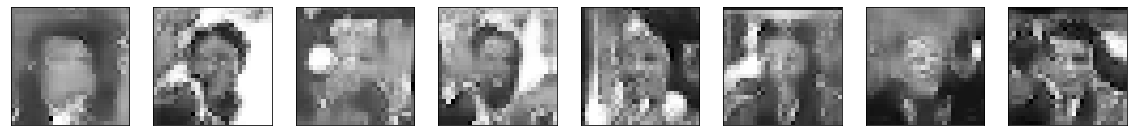

[Step 40000] D Loss: 0.7510; G Loss: 0.9528


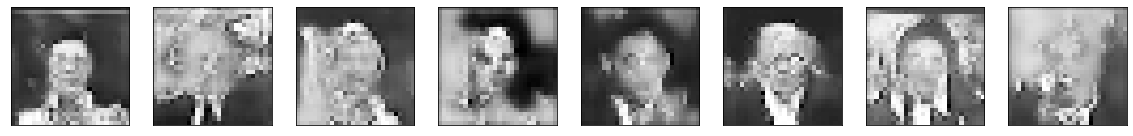

[Step 40500] D Loss: 0.6002; G Loss: 0.6931


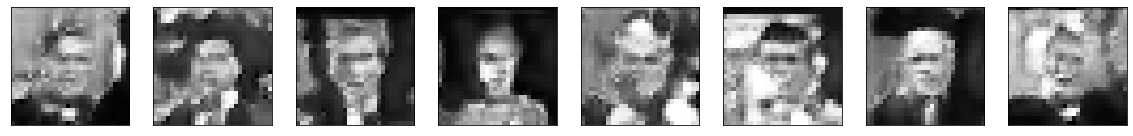

[Step 41000] D Loss: 0.5956; G Loss: 0.8038


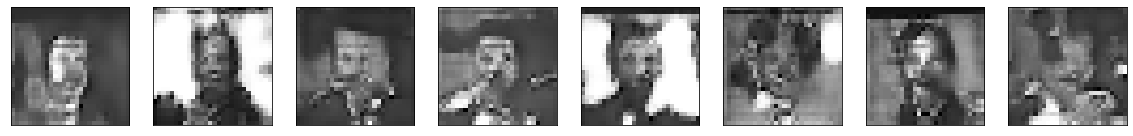

In [14]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)


## Тестирование свёрточного генератора

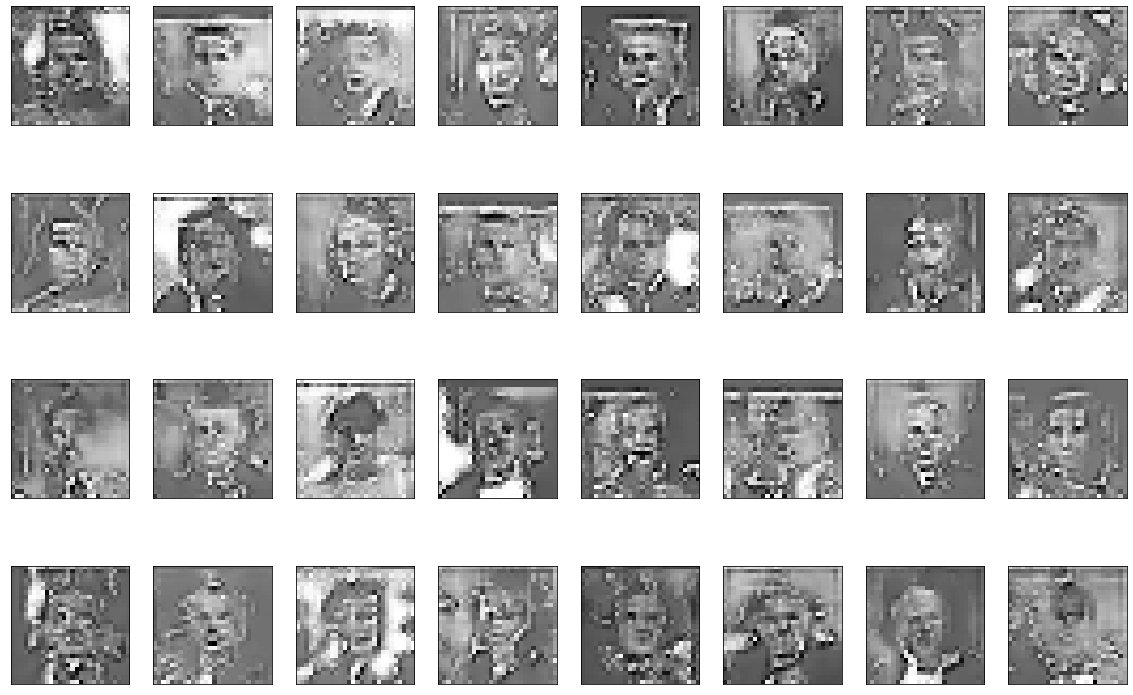

In [29]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)

## Интерполяция в латентном пространстве

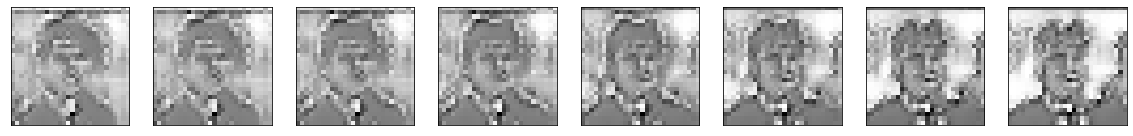

In [28]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)